### Pulmonary Fibrosis Model
#### DSISS 2022

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from tqdm.notebook import tqdm
from tqdm import trange

%matplotlib inline
sns.set_theme()

import os, datetime, random, math, glob, pydicom, warnings
import pickle, cv2, pylibjpeg
from pathlib import Path
 
import torch, torchviz, torchvision
from torch import nn
from torchsummary import summary
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader

#### Gathering dataset

In [3]:
base_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/"
os.listdir(base_dir)

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [4]:
train_df = pd.read_csv(os.path.join(base_dir,"train.csv"))
test_df = pd.read_csv(os.path.join(base_dir,"test.csv"))

print(train_df.shape)
train_df.head(10)

(1549, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker


#### Dataset exploration

In [5]:
print("--- Train data ---\n")
print(train_df.describe())
print("\nMissing values: \n", train_df.isnull().sum(), sep="")
print("\n--- Test data ---")
print(test_df.describe())
print("\nMissing values: \n", test_df.isnull().sum(), sep="")

--- Train data ---

             Weeks          FVC      Percent          Age
count  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509
std      23.247550   832.770959    19.823261     7.057395
min      -5.000000   827.000000    28.877577    49.000000
25%      12.000000  2109.000000    62.832700    63.000000
50%      28.000000  2641.000000    75.676937    68.000000
75%      47.000000  3171.000000    88.621065    72.000000
max     133.000000  6399.000000   153.145378    88.000000

Missing values: 
Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

--- Test data ---
           Weeks          FVC    Percent        Age
count   5.000000     5.000000   5.000000   5.000000
mean    8.800000  2781.600000  75.997702  71.800000
std     7.049823   516.475846   4.970960   2.167948
min     0.000000  1930.000000  70.186855  68.000000
25%     6.00000

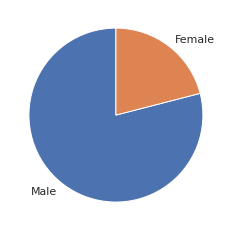

In [6]:
plt.pie(train_df.Sex.value_counts(), labels=["Male","Female"], startangle=90)
plt.show()

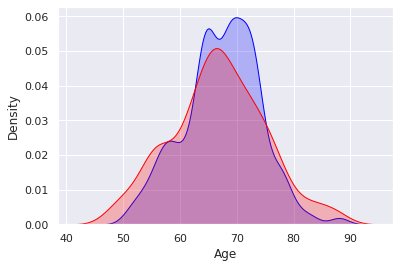

In [7]:
sns.kdeplot(train_df[train_df.Sex == "Male"].Age, color="blue", shade=True)
sns.kdeplot(train_df[train_df.Sex == "Female"].Age, color="red", shade=True)
plt.show()

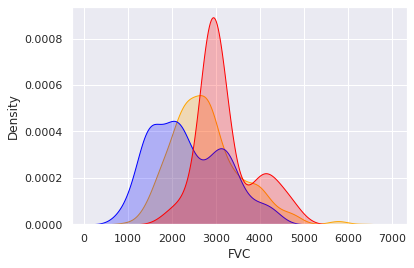

In [8]:
sns.kdeplot(train_df[train_df.SmokingStatus == "Ex-smoker"].FVC, color="orange", shade=True)
sns.kdeplot(train_df[train_df.SmokingStatus == "Never smoked"].FVC, color="blue", shade=True)
sns.kdeplot(train_df[train_df.SmokingStatus == "Currently smokes"].FVC, color="red", shade=True)
plt.show()

#### Dataset processing

In [9]:
class PulmonaryDataset(Dataset):
    def __init__(self, csv_file, base_dir="/kaggle/input/osic-pulmonary-fibrosis-progression/", target='train',transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.transform = transform
        self.target = target             
        
    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, idx):
        img_folder = os.path.join(self.base_dir,self.target,self.csv_data.iloc[idx].Patient)
        
        ## GETTING ONLY FIRST IMAGE FOR THE PATIENT
        for img_path in os.listdir(img_folder):
            img = pydicom.read_file(os.path.join(img_folder, img_path))
            try:
                img = cv2.resize(img.pixel_array.astype(float)/2**11, (224,224))
                stacked_img = np.stack((img,)*3, axis=-1)
            except Exception as e:
                print("Compressed image found.. retrying")
                img_array = img.decompress('pillow')
                img = cv2.resize(img.pixel_array.astype(float)/2**11, (224,224))
                stacked_img = np.stack((img,)*3, axis=-1)
            
            gender_label = {
                'Male': 1,
                'Female': 0
            }
            
            smoker_label = {
                'Never smoked': -1,
                'Ex-smoker': 0,
                'Currently smokes': 1
            }
            
            tab_data = np.array([self.csv_data.iloc[idx].Age, gender_label[self.csv_data.iloc[idx].Sex],
                        smoker_label[self.csv_data.iloc[idx].SmokingStatus]])
            
            return {'features': tab_data, 'image': stacked_img, 'target': self.csv_data.iloc[idx].FVC}

##### Some more exploration...

1 Shape: (224, 224, 3) Features: [60  1  0] Target: 2962


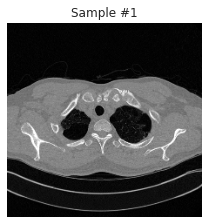

In [10]:
pulmonary_dataset = PulmonaryDataset(csv_file=os.path.join(base_dir,"train.csv"), base_dir = base_dir, target='train')

fig=plt.figure(figsize=(16, 16))
n_rows = 3
n_cols = 4

datapoint = pulmonary_dataset[np.random.choice(range(len(pulmonary_dataset)))]

print(1, f"Shape: {datapoint['image'].shape} Features: {datapoint['features']} Target: {datapoint['target']}" )

ax = fig.add_subplot(n_rows, n_cols, 1)
ax.set_title(f'Sample #{1}')
ax.axis('off')
plt.imshow(datapoint['image'])

plt.show()

In [11]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super(ResNetBlock, self).__init__()
        
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()
            
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = x + shortcut
        return nn.ReLU()(x)

In [12]:
class PulmonaryResNetModel(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1):
        super(PulmonaryResNetModel, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        
        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False),
            resblock(128, 128, downsample=False),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False),
            resblock(256, 256, downsample=False),
            resblock(256, 256, downsample=False),
            resblock(256, 256, downsample=False),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False),
            resblock(512, 512, downsample=False),
        )
        
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc_resnet = torch.nn.Linear(512, 64)
        
        self.layer_tab = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
        )
        
        self.fc_model = torch.nn.Linear(128, 1)
        
    def forward(self, x_img, x_tab):
        x_img = self.layer0(x_img)
        x_img = self.layer1(x_img)
        x_img = self.layer2(x_img)
        x_img = self.layer3(x_img)
        x_img = self.layer4(x_img)
        x_img = self.gap(x_img)
        x_img = self.flatten(x_img)
        x_img = self.fc_resnet(x_img)
        
        x_tab = self.layer_tab(x_tab)
        
        x = torch.cat((x_img,x_tab),1)
        x = self.fc_model(x)
        
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PulmonaryResNetModel(3,ResNetBlock)
model.to(device)

print(model)

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
x_tab = torch.zeros(1,3 , dtype=torch.float, requires_grad=False)
out = model(x, x_tab)

dot = make_dot(out)
dot.format = 'png'
dot.render('model_graph')

PulmonaryResNetModel(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, m

'model_graph.png'

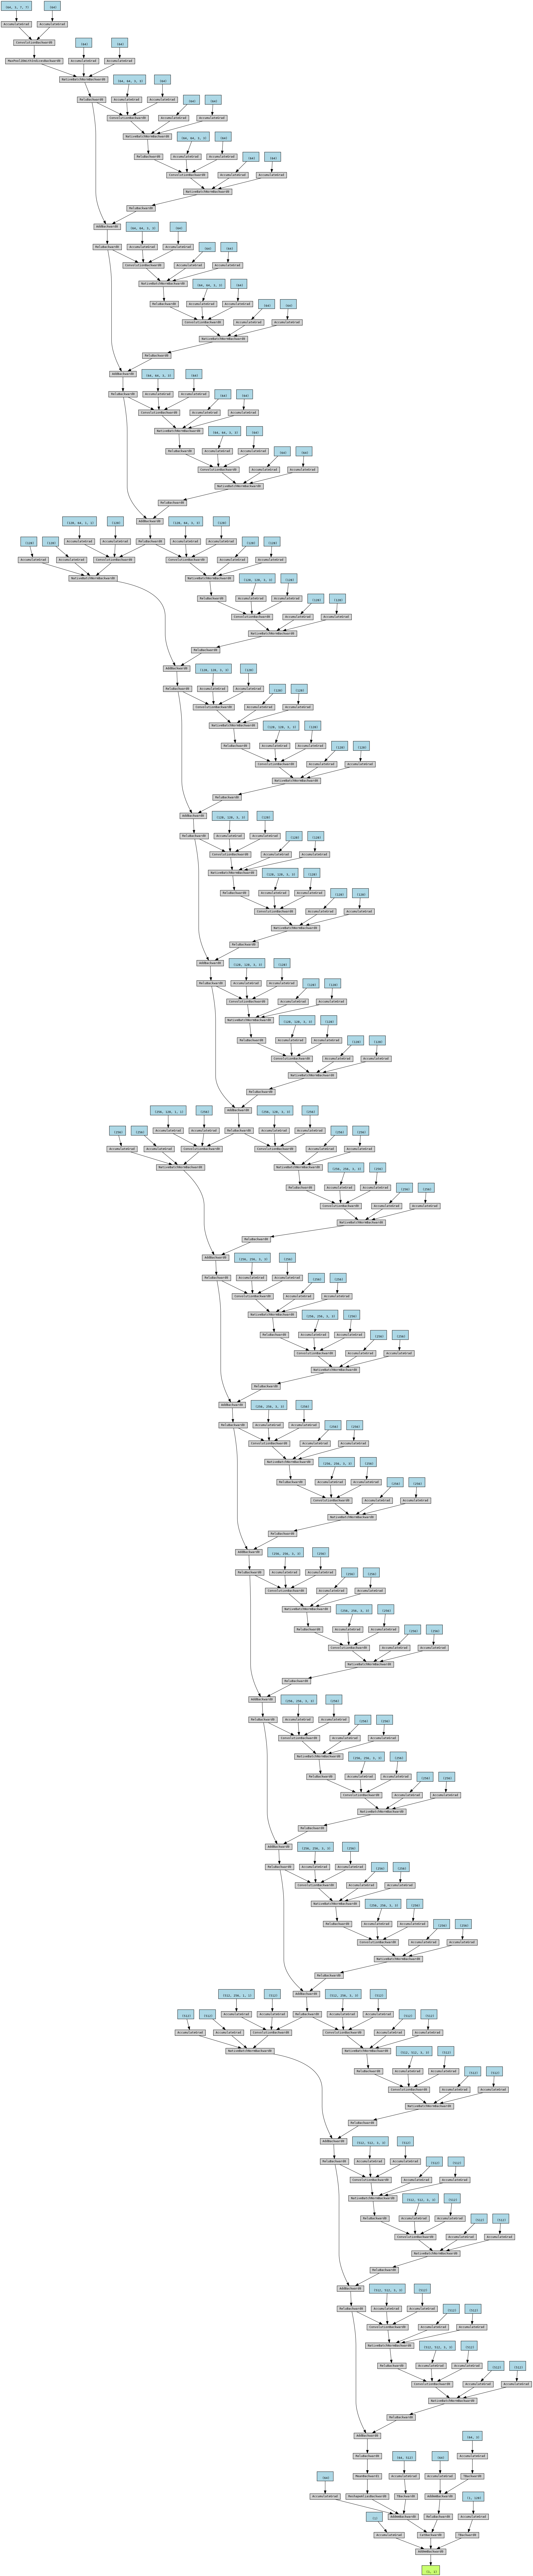

In [14]:
output_path = "/kaggle/working"

from IPython.display import Image
Image(filename=os.path.join(output_path,"model_graph.png")) 